# Importing modules and input data

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv("X_train.csv",sep=";",decimal=",",header=None)
df_2 = pd.read_csv("y_train.txt",header=None)

# Modification of data using the features with highest target correlation

In [2]:
df_2.columns = ["target"]
df_merged=df.join(df_2)
df_corr=df_merged.corrwith(df_merged["target"])
df_sorted=df_corr.sort_values(ascending=False)
df_correlated=df_sorted.head(n=50)
df_correlated=df_correlated.to_frame()
df_correlated=df_correlated.index.tolist()
df_correlated_cleared=df_correlated.copy()
df_correlated_cleared.remove("target")

# PCA to reduce dimensionality to 2 together with KMeans method

In [3]:
X = df_merged[df_correlated_cleared]
Model = PCA(n_components=2)
X_new = Model.fit_transform(X)
clf = KMeans(n_clusters=6,max_iter=10,random_state=1)

y_pred = clf.fit_predict(X_new)

# Visualization of clusters

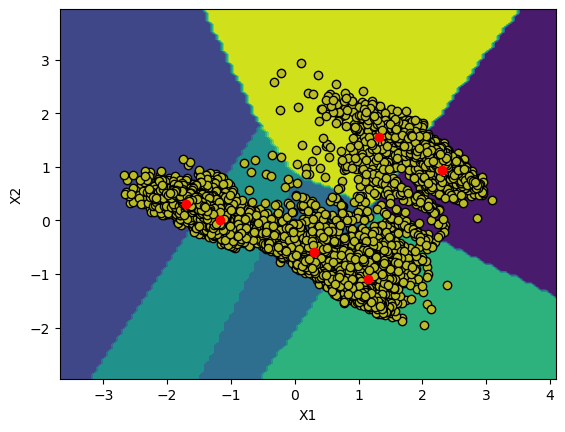

In [4]:
display = DecisionBoundaryDisplay.from_estimator(

    clf,X_new, response_method="predict"
)

display.ax_.scatter(

    X_new[:,0], X_new[:,1], c='#bcbd24', edgecolor="black"

)

display.ax_.scatter(

    clf.cluster_centers_[:,0], clf.cluster_centers_[:,1], c='red'

)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Visualize the six classes

Text(0, 0.5, 'y')

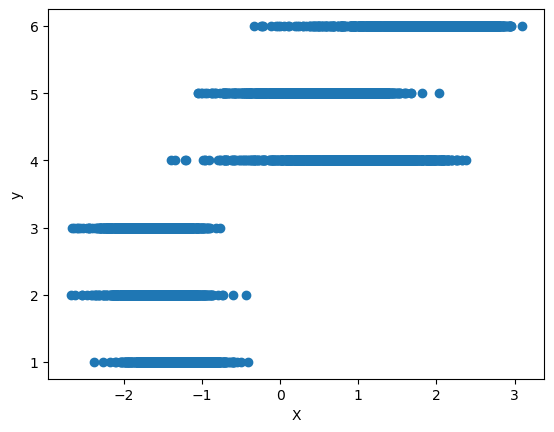

In [5]:
plt.scatter(X_new[:,0],df_merged["target"])
plt.xlabel("X")
plt.ylabel("y")

### The algorithm works best for class 5 and 6 (standing and lying). The other classes are problematic. This is probably due to the fact, that most of them involve some kind of movement. Overall, the clustering is not effective in this case.

# MiniBatchKMeans method and visualization

In [6]:
# metoda MiniBatchKMeans
MBKMeans_clf = MiniBatchKMeans(n_clusters=6, max_iter=10, random_state=1)
y_pred_2=MBKMeans_clf.fit_predict(X_new)

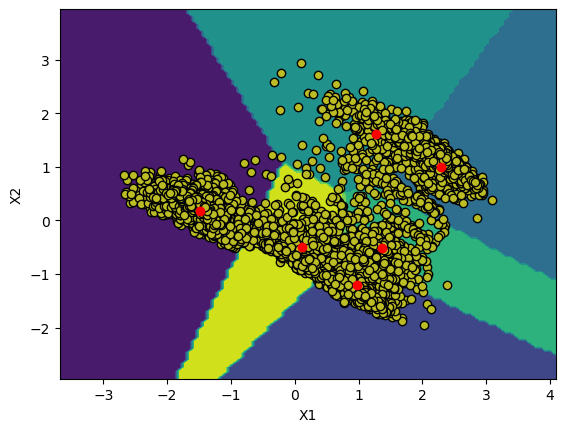

In [7]:
display = DecisionBoundaryDisplay.from_estimator(

    MBKMeans_clf,X_new, response_method="predict"

)

display.ax_.scatter(

    X_new[:,0], X_new[:,1], c='#bcbd24', edgecolor="black"

)

display.ax_.scatter(

    MBKMeans_clf.cluster_centers_[:,0], MBKMeans_clf.cluster_centers_[:,1], c='red'

)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### The clustering is pretty similar, although the positioning is somewhat different.

# DBSCAN model and visualization

In [8]:
# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=5)
y_scan_1=dbscan.fit_predict(X_new)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=200)
y_scan_2=dbscan_2.fit_predict(X_new)

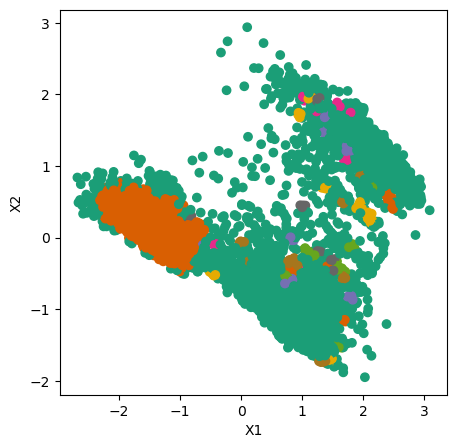

In [9]:
plt.figure(figsize=(5,5))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_scan_1, cmap='Dark2')

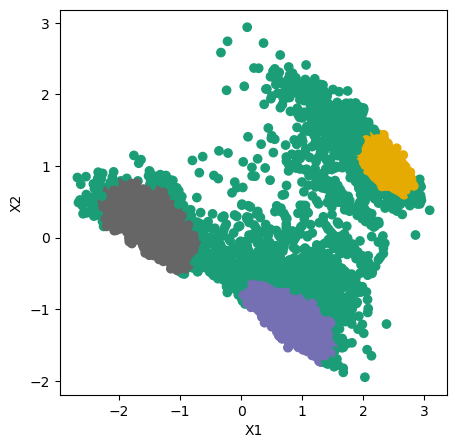

In [10]:
plt.figure(figsize=(5,5))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_scan_2, cmap='Dark2')

### The clustering is more effective for a bigger epsioln. Still, the clustering is not very satisfying.

# GMM model and visualization

In [11]:
gm = GaussianMixture(n_components=50, n_init=20, random_state=42)
gm.fit(X_new)

GaussianMixture(n_components=50, n_init=20, random_state=42)

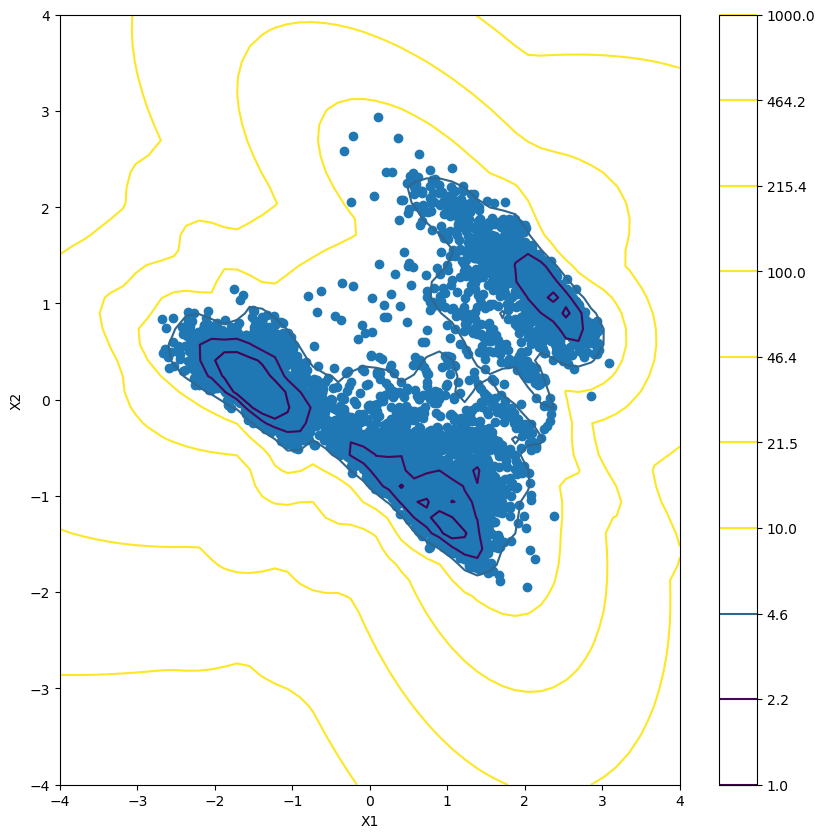

In [12]:
x = np.linspace(-4.0, 4.0)
y = np.linspace(-4.0, 4.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)
Z = Z.reshape(X.shape)
plt.figure(figsize=(10,10))
contour = plt.contour(
    X, Y, Z, vmin=2.0, vmax=10, levels=np.logspace(0, 3, 10)
)
plt.colorbar(contour)
plt.scatter(X_new[:, 0], X_new[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### The clustering is not very satisfying again.

# Finding the best number of clusters for KMeans

In [13]:
# tworzymy 19 algorytmów z k od 1 do 19
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2).fit(X_new)
    for k in range(2, 20) # zaczynamy od wartości n_clusters wynoszącej 2, gdyż nie ma sensu dzielenia zbioru dla 1 klastra
]

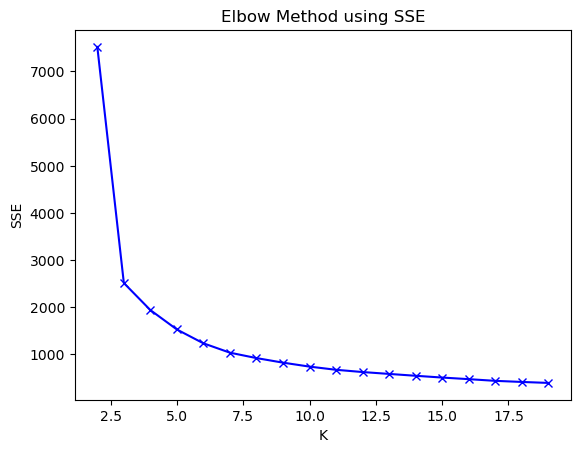

In [14]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

In [15]:
silhouette_scores = [
    silhouette_score(X_new, model.labels_)
    for model in kmeans_per_k
]

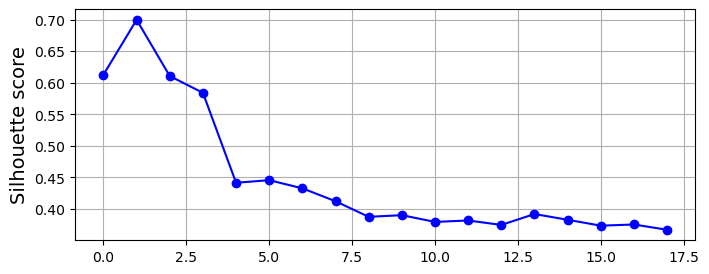

In [16]:
plt.figure(figsize=(8, 3))
plt.plot(silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

### Although 2 is the best number of clusters, 6 is selected due to the fact that 6 classes are present.

# Validation scores for logistic regression

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_new, df_merged["target"], test_size=0.30, random_state=0,stratify=df_merged["target"])
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_predicted_lr=model_lr.predict(X_test)

In [18]:
f1_lr = f1_score(y_test, y_predicted_lr,average="weighted")

In [19]:
f1_lr

0.687930755638727

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)

In [21]:
kf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# stworzenie klasyfikatora
clf = LogisticRegression(max_iter=1000)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X_new, df_merged["target"], cv=kf)
print("wynik kroswalidacji KFold: ", cv_score)
print("średni wynik wszystkich foldów KFold: ", cv_score.mean())
cv_score_2 = cross_val_score(clf, X_new, df_merged["target"], cv=kf2)
print("wynik kroswalidacji StratifiedKFold: ", cv_score_2)
print("średni wynik wszystkich foldów StratifiedKFold: ", cv_score_2.mean())

wynik kroswalidacji KFold:  [0.6832087  0.72467709 0.68503401 0.68911565 0.71156463]
średni wynik wszystkich foldów KFold:  0.6987200155385063
wynik kroswalidacji StratifiedKFold:  [0.70768185 0.68728756 0.69183673 0.70408163 0.69591837]
średni wynik wszystkich foldów StratifiedKFold:  0.6973612286518958


# Validation scores for SVM

In [22]:
model_svm = SVC(kernel='rbf', probability=True)
model_svm.fit(X_train, y_train)
y_predicted_svm=model_svm.predict(X_test)

In [23]:
f1_svm = f1_score(y_test, y_predicted_svm,average="weighted")

In [24]:
f1_svm

0.6841470839411781

In [25]:
# stworzenie klasyfikatora
clf = SVC(kernel='rbf', probability=True)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X_new, df_merged["target"], cv=kf)
print("wynik kroswalidacji KFold: ", cv_score)
print("średni wynik wszystkich foldów KFold: ", cv_score.mean())
cv_score_2 = cross_val_score(clf, X_new, df_merged["target"], cv=kf2)
print("wynik kroswalidacji StratifiedKFold: ", cv_score_2)
print("średni wynik wszystkich foldów StratifiedKFold: ", cv_score_2.mean())

wynik kroswalidacji KFold:  [0.6900068  0.71991842 0.69455782 0.69863946 0.71292517]
średni wynik wszystkich foldów KFold:  0.7032095339835458
wynik kroswalidacji StratifiedKFold:  [0.7110809  0.68660775 0.70680272 0.71292517 0.70272109]
średni wynik wszystkich foldów StratifiedKFold:  0.7040275253541253


### All validation scores are decent for the supervised learning.

### The KMeans method clusters the given data with respect to the given amount of cluster.s The K-fold method splits the data set into train and test sets with subsequent folds that vary in the distribution of train and test sets. The K Nearest Neighbors method finds a set amount of points with the lowest distance to a new point and predicts by using these data points. Reference for the data : Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 